This notebook investigates and documents methods for studying Bose-Einstein Condensation and vortices at finite temperatures. It dives into the theory needed for the models and ways of implementing it in Python.

### Overview

In this notebook, we assume that the temperature of the system corresponds to one whose energy is higher than the chemical potential. For weakly interacting Bose gases, the chemical potential, which is associated with the interaction energy $E_{int} = gn$ is close to zero. As a result, most studies of weak interacting Bose gases characterize the energy regime above the chemical potential, but below the critical temperature $T_c$ where the Bose-Einstein Condensate evaporates. 

In this regime, the wave-particle duality of quantum mechanics is still important, but the quantum fluctuations are negligable. This phenomenon is due to the fact that below the chemical potential, the interaction strength is still non-negligable and there are strong entanglement properties as a result. The entanglement properties lead to quantum fluctuations, which contribute quantum noise. Above the chemical potential, the interactions become more negligable and the quantum fluctuations disappear. Consequently, the thermal noise dominates the system over the quantum noise, but are not so strong that quantum degeneracy disapears. 



### The Setup
To implement, as before, we choose a grid spacing $\Delta x$, which corresponds to a maximum $k$ value $k_{max} = \pi/\Delta x$. It is also important to note that the resolution in $k$ is determined by the length of the 2D box trap $L$ via the relationship $\Delta k = 2\pi/L$. The temperature is approximately equal to the kinetic energy, since it is assumed that the interactions are weak. Thence, $T = k_{max}^2/2m$. 

We can form a probability distribution for a given $k$ mode and then sample from it to create the appropriate thermal noise. Namely, 
\begin{equation}
P(\{\psi_k\}) \propto e^{(-|\psi_k|^2\frac{k^2}{2m}\frac{1}{k_BT})}. 
\end{equation}

Consequently, the full initial wavefunction can be modeled as 
\begin{equation}
P(\{\psi\}) \propto \prod_{k} e^{(-|\psi_k|^2\frac{k^2}{2m}\frac{1}{k_BT})}. 
\end{equation}

We can thence take samples of this distribution and create an ensemble of thermal noise to add to the initial GPE wavefunction. We can assume that the following expression is true 
\begin{equation}
\psi_{total} = \psi_{gpe} + \psi_{thermal}. 
\end{equation}
This holds true because the thermal noise component is only valid on large enough $k$, while the vortex and GPE solution is only valid in $k$ smaller than the healing length. 

We determine $\psi_k$ based on Gaussian random numbers. 
\begin{equation}
\psi_k = \sqrt{\frac{k_BT}{2k^2/2m}}(\text{randn} + i\text{randn})
\end{equation}

This randomness corresponds to the randomness associated with thermal noise. The Gaussian random noise is centered around zero with unit variance. 

### Some assumptions for our model

We are setting a $k_{max}$ cutoff for the momenta of the system. In this regime, based on the Bose-Einstein distibution function, there should still be a macroscopic occupation of the ground and lower energy states and we have chosen a sufficiently reasonable cutoff for $k$ such that the average occupancy of a given mode does not approach $0$. Namely, we remove the high energy modes from our model, as we are working with a classical model. 

With the Bogoliubov dispersion relationship, the energy obeys the classical $E = k^2/2m$ and hence has a quadratic relationship when the temperature is on order or larger of the interaction energy. The relationship between energy and the wavenumber are linear below the temperature associated with the interaction energy. Therefore, we choose a temperature such that the kinetic energy of a mode is larger than the interaction energy of that mode to work with this quadratic version of the kinetic energy. 

In summary, we need to set certain parameters to ensure that are classical assumptions remain true: 
1. Set a maximum wavenumber "cutoff" point $k_{max}$ to ensure that we are working with lower energy states and to ensure that the energy of the system does not diverge via the ultraviolet catastrophe. 
2. Set a minimum temperature such that we study the regime where the kinetic energy is larger than the interaction energy, the regime of inteerest for weakly interacting Bose systems. 


# Steps for Implementation

1. Define the new parameters including setting a maximum $k$ and the corresponding temperature 
2. Create a function to define $\psi_k$ based on Gaussian random numbers. The random numbers introduce noise associated with the thermal randomness at finite temperatures 
3. Create a function to generate the probability distribution $P$ for a given $k$ mode 
4. Create a function to generate the total probability distibution function by taking the product for each probability distibution function found in (3) corresponding to each $k$ in the grid 
5. Do this $N_{samples}$ times to create an ensemble of probability distributions generated via random numbers to pass into the probability
6. Normalize! The expected result when the $k^2/2mk_BT$ term goes to zero is $k_BT/(k^2/2m)$
7. Find the inverse Fourier transform of this value to revert back to real space 
8. Add each of these new thermal wavefunction to the original GPE wavefunction with vortices after imaginary time evolution is complete 
9. Evolve the entire new wavefunctions in real time 
10. Take the average over the time evolved wavefunctions with thermal noise to find that the momenta distribution smooths out in an exponential-like shape 


# Implementing the Code

Let's take some of the code from vortexclean.py to test this new model

In [1]:
import numpy as np
from scipy.fft import fft2, ifft2, fftshift, ifftshift
import matplotlib.pyplot as plt
from vortexclean import GPETimeEv as gpev

In [2]:
g = gpev(L = 50, dim = 2, numImagSteps = 500, runDyn = False)

Total Imag Time:  51.97542905807495


Now, let's take the functions that we have already written for the vortex simulations via vortexclean.py. 

In [3]:
# set parameters
L = 50 
npoints = 2**9 
winL = 2*L 
dx = winL/npoints 
dim = 2 

In [52]:
def setxgrid(): 
    '''
    Set up the x grid containing discrete values to evaluate the GPE on. The grid is evaluated over a window around the box potential 
    '''

    # set x grid 
    axes = [] 
    for i in range(dim): 

        axes.append(np.linspace(-winL/2,(npoints-1)*dx-winL/2,npoints) )
        
    axes_arr = np.array(axes) 
    xi = np.meshgrid(*axes_arr) 
    return xi 
    
def setpgrid(): 
    '''
    Set up the momentum (p) grid containing discrete momentum values corresponding to the spatial values defined in setxgrid() 
    '''
    paxes = [] 
    for i in range(dim): 
        paxes.append(ifftshift(np.linspace(-np.pi/dx, (npoints - 1) * (2*np.pi)/winL - (np.pi/dx), npoints))[1:]) # do not count the zero momentum state 
    paxes_arr = np.array(paxes) 

    ki = np.meshgrid(*paxes_arr) 
    dk = 2*np.pi/(dx * npoints)
    kmax = np.pi / dx 

    T = kmax**2/2  # sets the temperature based on kmax 

    return ki, dk, T 

In [368]:
print(ki[0][:,1:].shape)
print(ki[1][0])

(511, 510)
[0.06283185 0.06283185 0.06283185 0.06283185 0.06283185 0.06283185
 0.06283185 0.06283185 0.06283185 0.06283185 0.06283185 0.06283185
 0.06283185 0.06283185 0.06283185 0.06283185 0.06283185 0.06283185
 0.06283185 0.06283185 0.06283185 0.06283185 0.06283185 0.06283185
 0.06283185 0.06283185 0.06283185 0.06283185 0.06283185 0.06283185
 0.06283185 0.06283185 0.06283185 0.06283185 0.06283185 0.06283185
 0.06283185 0.06283185 0.06283185 0.06283185 0.06283185 0.06283185
 0.06283185 0.06283185 0.06283185 0.06283185 0.06283185 0.06283185
 0.06283185 0.06283185 0.06283185 0.06283185 0.06283185 0.06283185
 0.06283185 0.06283185 0.06283185 0.06283185 0.06283185 0.06283185
 0.06283185 0.06283185 0.06283185 0.06283185 0.06283185 0.06283185
 0.06283185 0.06283185 0.06283185 0.06283185 0.06283185 0.06283185
 0.06283185 0.06283185 0.06283185 0.06283185 0.06283185 0.06283185
 0.06283185 0.06283185 0.06283185 0.06283185 0.06283185 0.06283185
 0.06283185 0.06283185 0.06283185 0.06283185 0.0628

In [253]:
def genPsiK(T, k): 
    '''
    Generates the wavefunction psi randomly for a given k based on coefficients generated based on Gaussian random numbers 
    '''
    randr, randi = np.random.normal(size = 2) 
    
    # coefs1 = np.sqrt(T)/k[0][:,1:]
    # coefs2 = np.sqrt(T)/k[1][1:]

    coef = np.sqrt(T/(k[0]**2 + k[1]**2))


    return coef * (randr + 1j * randi)


def genProbK(k, psik, T, dk): 
    '''
    Generates the probability for the set of wavefunctions in k space based on the product of the individual probabilities 
    '''

    prob = np.exp(-np.abs(psik)**2 * (k[0][0][0]**2)/(2*T))
    for kval in range(len(k)-1):
        temp = np.exp(-np.abs(psik)**2 * ((k[0][0][kval+1])**2)/(2*T))
        prob = np.multiply(temp, prob) 
        #prob *= np.exp(-np.abs(psik)**2 * ((k[0][0][kval+1])**2)/(2*T))

    norm = np.sum(np.abs(prob)) * dk**2

    return prob / norm 


In [254]:
print(np.shape(probk))

(511, 511)


In [255]:
xi = setxgrid() 
ki, dk, T = setpgrid() 
print(ki[0].shape)
#print(ki[1][1:].shape)

psik = genPsiK(T, ki) 

probk = genProbK(ki, psik, T, dk)


print(np.sum(np.abs(probk))*dk**2) # check normalization


(511, 511)
0.9999999999999998


In [359]:
sqpsi = np.abs(psik)**2

def calcLimit(psik, karr, T):
    calc_values = []
    limit_values = [] 
    k_values = [] 
    print(np.shape(karr[0][0]))
    for i in range(len(karr[0])):
        for j in range(len(karr[0][0])):
            if np.abs(karr[0][0][j]) < 0.08: 
                print(j)
                print(karr[0][0][j])
                k = karr[0][0][j]
                limit = T/(k**2/2)
                theory = psik[i][j]**2 ## find the expectation value of this, not just the value at a given k 
                limit_values.append(limit)
                calc_values.append(theory)
                k_values.append(k)

    return limit_values, calc_values, k_values



def calcLimit2(psik, karr, T, dk): 
    # find the calculated value of the expectation value
    #expected_value = np.sum(np.conj(psik) * karr * psik) * dk **2
    
    #expected_value = (np.real(psik)**2 + np.imag(psik)**2) * np.exp(-(np.real(psik)**2 + np.imag(psik)**2)*(karr[0]**2 + karr[1]**2)/(2*T)) * np.sqrt(np.real(psik)**2 + np.imag(psik)**2)*dk

    # retry the calculation for expected value
    r2 = (np.real(psik)**2 + np.imag(psik)**2)
    exp_value = np.zeros_like(karr[0]) 

    for i in range(len(karr[0])):
        print(i)
        for j in range(len(karr[0][0])): 
            res = np.sum(r2 * np.sqrt(r2) * np.exp(-r2 * (karr[0][i][j]**2+karr[1][i][j]**2)/(2*T)))*dk**2
            exp_value[i][j] = res 

    # find the theoretical value

    theoretical_value = T/(karr[0]**2 + karr[1]**2)

    return exp_value, theoretical_value, karr


In [360]:
interim_results = calcLimit2(psik, ki, T, dk)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [336]:
print(interim_results[0]*dk**2) 
print(interim_results[1])

[[40.13836281 39.92037639 39.20146536 ... 39.20146536 39.92037639
  40.13836281]
 [39.92037639 39.53542283 38.61308887 ... 38.61308887 39.53542283
  39.92037639]
 [39.20146536 38.61308887 37.49785121 ... 37.49785121 38.61308887
  39.20146536]
 ...
 [39.20146536 38.61308887 37.49785121 ... 37.49785121 38.61308887
  39.20146536]
 [39.92037639 39.53542283 38.61308887 ... 38.61308887 39.53542283
  39.92037639]
 [40.13836281 39.92037639 39.20146536 ... 39.20146536 39.92037639
  40.13836281]]
[[16384.          6553.6         3276.8        ...  3276.8
   6553.6        16384.        ]
 [ 6553.6         4096.          2520.61538462 ...  2520.61538462
   4096.          6553.6       ]
 [ 3276.8         2520.61538462  1820.44444444 ...  1820.44444444
   2520.61538462  3276.8       ]
 ...
 [ 3276.8         2520.61538462  1820.44444444 ...  1820.44444444
   2520.61538462  3276.8       ]
 [ 6553.6         4096.          2520.61538462 ...  2520.61538462
   4096.          6553.6       ]
 [16384.       

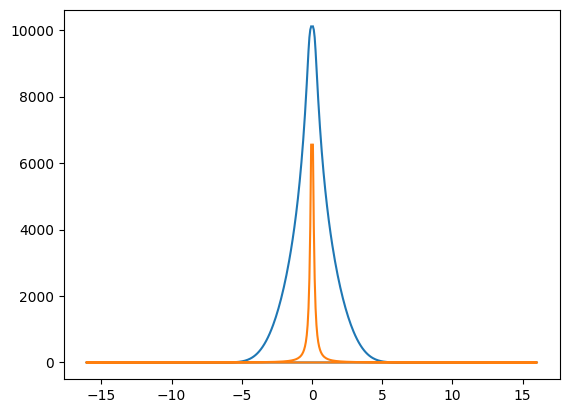

In [358]:
plt.figure() 
plt.plot(ki[0][0], interim_results[0][len(interim_results)//2])
plt.plot(ki[0][0], interim_results[1][len(interim_results)//2])

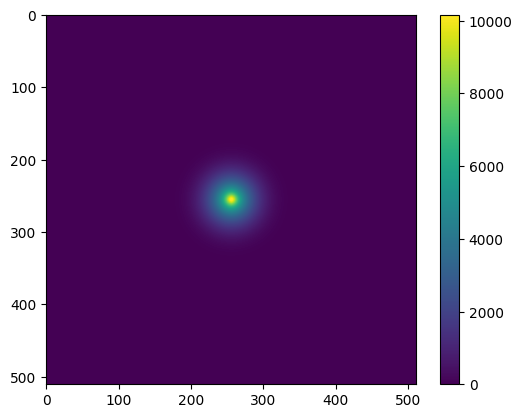

In [347]:
plt.figure() 
plt.imshow(ifftshift(np.abs(interim_results[0])))
plt.colorbar() 
plt.show() 

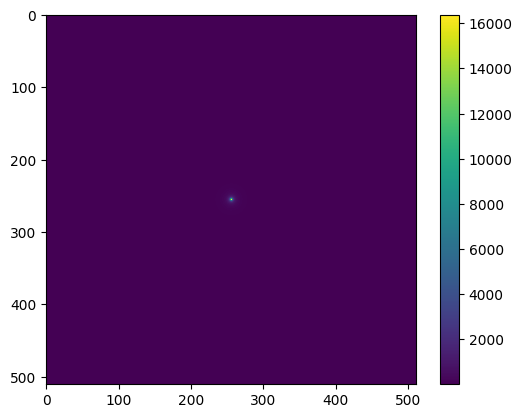

In [348]:
plt.figure() 
plt.imshow(ifftshift(interim_results[1])) 
plt.colorbar() 
plt.show() 

In [318]:
print(np.shape(interim_results[0]))
print(np.shape(interim_results[1]))

(511, 511)
(511, 511)


In [276]:
print(len(ki[0][0][np.abs(ki[0][0])<0.08]))

2


In [285]:
inter_results = calcLimit(psik, ki, T)

(511,)
0
0.06283185307179551
510
-0.06283185307179551
0
0.06283185307179551
510
-0.06283185307179551
0
0.06283185307179551
510
-0.06283185307179551
0
0.06283185307179551
510
-0.06283185307179551
0
0.06283185307179551
510
-0.06283185307179551
0
0.06283185307179551
510
-0.06283185307179551
0
0.06283185307179551
510
-0.06283185307179551
0
0.06283185307179551
510
-0.06283185307179551
0
0.06283185307179551
510
-0.06283185307179551
0
0.06283185307179551
510
-0.06283185307179551
0
0.06283185307179551
510
-0.06283185307179551
0
0.06283185307179551
510
-0.06283185307179551
0
0.06283185307179551
510
-0.06283185307179551
0
0.06283185307179551
510
-0.06283185307179551
0
0.06283185307179551
510
-0.06283185307179551
0
0.06283185307179551
510
-0.06283185307179551
0
0.06283185307179551
510
-0.06283185307179551
0
0.06283185307179551
510
-0.06283185307179551
0
0.06283185307179551
510
-0.06283185307179551
0
0.06283185307179551
510
-0.06283185307179551
0
0.06283185307179551
510
-0.06283185307179551
0
0.06

In [289]:
print(inter_results[2])

[0.06283185307179551, -0.06283185307179551, 0.06283185307179551, -0.06283185307179551, 0.06283185307179551, -0.06283185307179551, 0.06283185307179551, -0.06283185307179551, 0.06283185307179551, -0.06283185307179551, 0.06283185307179551, -0.06283185307179551, 0.06283185307179551, -0.06283185307179551, 0.06283185307179551, -0.06283185307179551, 0.06283185307179551, -0.06283185307179551, 0.06283185307179551, -0.06283185307179551, 0.06283185307179551, -0.06283185307179551, 0.06283185307179551, -0.06283185307179551, 0.06283185307179551, -0.06283185307179551, 0.06283185307179551, -0.06283185307179551, 0.06283185307179551, -0.06283185307179551, 0.06283185307179551, -0.06283185307179551, 0.06283185307179551, -0.06283185307179551, 0.06283185307179551, -0.06283185307179551, 0.06283185307179551, -0.06283185307179551, 0.06283185307179551, -0.06283185307179551, 0.06283185307179551, -0.06283185307179551, 0.06283185307179551, -0.06283185307179551, 0.06283185307179551, -0.06283185307179551, 0.06283185

AttributeError: PathCollection.set() got an unexpected keyword argument 'width'

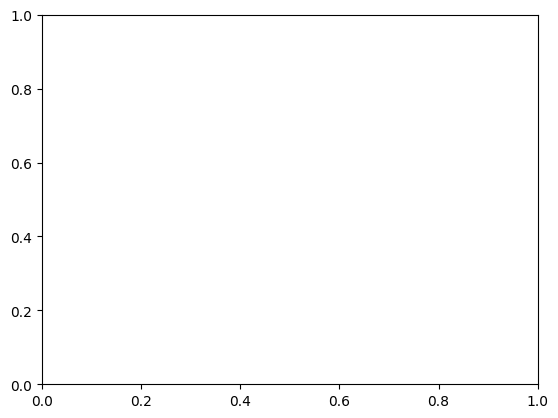

In [293]:
plt.figure() 
plt.scatter(inter_results[2], inter_results[0], width = 0.01)
plt.show() 

In [272]:
print(len(inter_results[1]))

1022


In [216]:
print(np.array(np.abs(inter_results[1])))

[10493.95090751 10493.95090751  4197.580363   ...  4197.580363
 10493.95090751 10493.95090751]


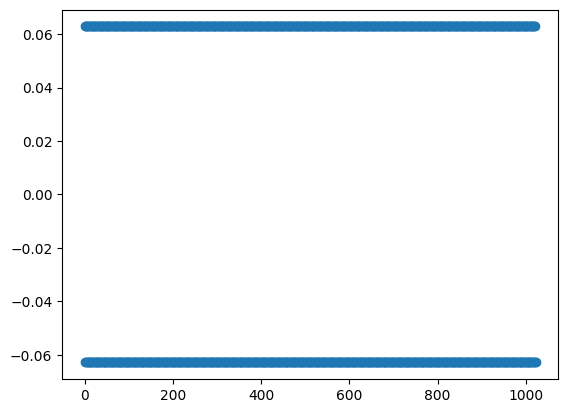

In [260]:
plt.figure()
plt.scatter(np.linspace(0,len(inter_results[1]), len(inter_results[1])), inter_results[2])

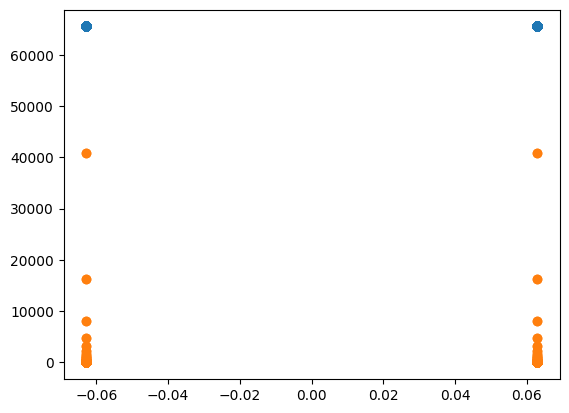

In [263]:
plt.figure() 
plt.scatter(np.array(inter_results[2]), np.array(inter_results[0]))
plt.scatter(np.array(inter_results[2]), np.array(np.abs(inter_results[1])))
plt.show() 

In [172]:
print(ki[0])

[[ 0.06283185  0.12566371  0.18849556 ... -0.18849556 -0.12566371
  -0.06283185]
 [ 0.06283185  0.12566371  0.18849556 ... -0.18849556 -0.12566371
  -0.06283185]
 [ 0.06283185  0.12566371  0.18849556 ... -0.18849556 -0.12566371
  -0.06283185]
 ...
 [ 0.06283185  0.12566371  0.18849556 ... -0.18849556 -0.12566371
  -0.06283185]
 [ 0.06283185  0.12566371  0.18849556 ... -0.18849556 -0.12566371
  -0.06283185]
 [ 0.06283185  0.12566371  0.18849556 ... -0.18849556 -0.12566371
  -0.06283185]]


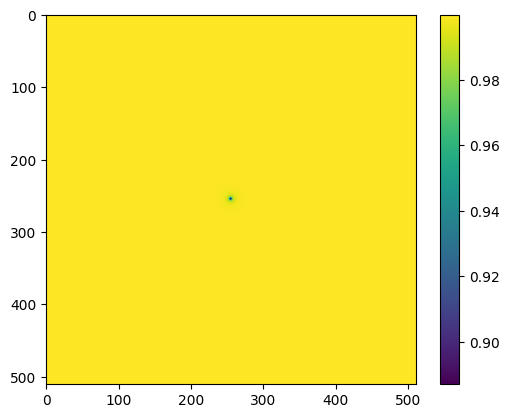

In [135]:
prob = np.exp(-np.abs(psik)**2* (ki[0][0][0]**2)/(2*T) )
plt.figure() 
plt.imshow(np.abs(fftshift(prob))) 
plt.colorbar() 
plt.show() 

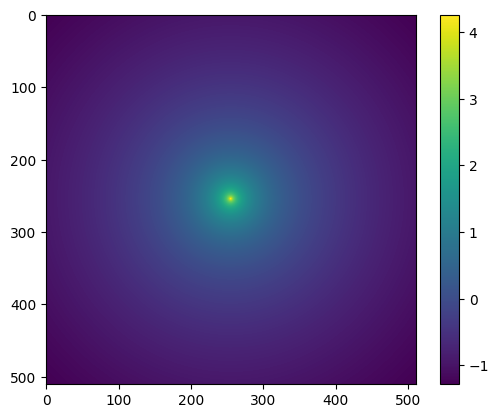

In [93]:
plt.figure() 
plt.imshow(np.log(np.abs(fftshift(psik))))
plt.colorbar() 
plt.show() 

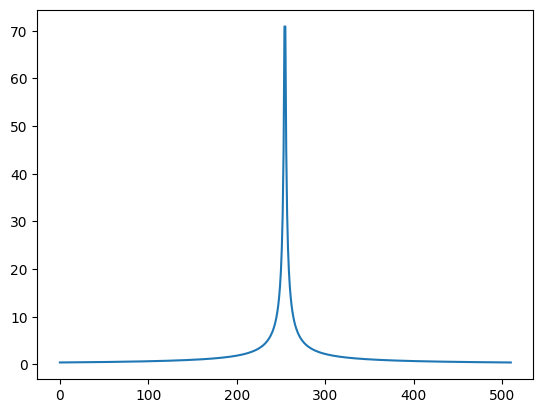

In [94]:
plt.figure() 
plt.plot(np.abs(fftshift(psik))[:,len(psik)//2])
#plt.scatter(ki[0][0], np.abs(psik)[:,0])
plt.show() 

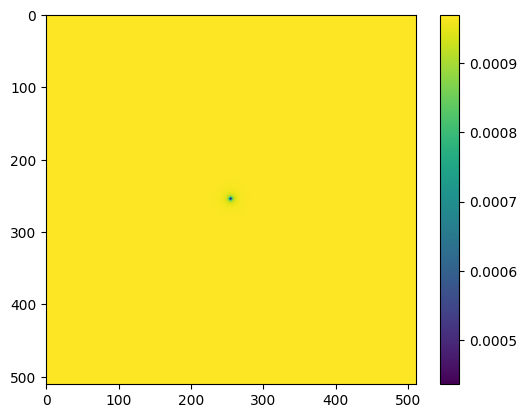

In [171]:
plt.figure() 
plt.imshow(np.abs(fftshift(probk)))
plt.colorbar() 
plt.show() 

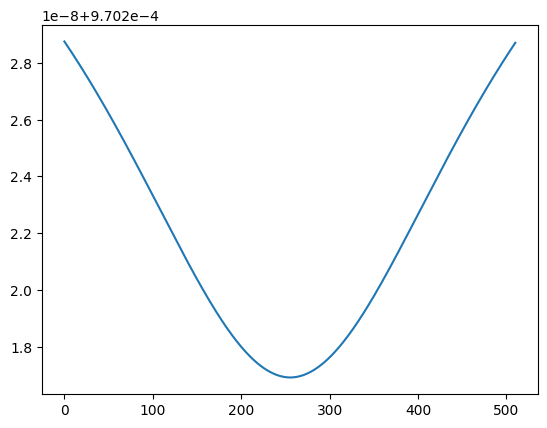

In [174]:
plt.figure() 
plt.plot(ifftshift(probk[len(probk)//2])) 
plt.show() 

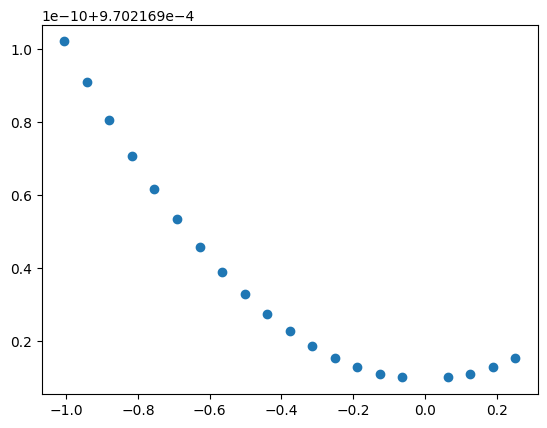

In [187]:
plt.figure() 
plt.scatter(ifftshift(ki[0][0])[240:260], ifftshift(probk[len(probk)//2])[240:260])
plt.show() 

### Notes and TODO items

I created a series of functions that allowed for the calculation of the probability distribution in $k$ space. This function is properly normalized to $1$. It is important to note that the distribution does not include the $k = 0$ term, so there is a hole present at $k = 0$ in each of the 2-dimensional plots. 

TODO: 
1. Make cleaner plots for the $\psi_k$ and the probability distribution - make the plots labeled and clear 
2. Make an assessment of if the plots make sense and calculate the expectation value. Note that the expectation value should be 

$<|\psi_k|> = \frac{k_BT}{k^2/2m}$

when $k \rightarrow 0$. 





Let's implement the time evolution of the wavefunction with classical noise. Here are the necessary steps to do so: 
1. Form the BEC wavefunction at assumed temperture = 0. This is the same as the initialization step in the vortex code. 
    - Add the vortices in this step as well as done before. 
    - This is the zero momentum regime and we assume time = 0 

2. Evolve the wavefunction in imaginary time to get to the ground state wavefunction 
3. ADD the wavefunction contribution from classical noise. This is done by simply taking the GPE wavefunction and adding the wavefunction from classical noise in real space. 
    - There are some things to note - namely the conversion from momentum space to real space 